In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from utils import *
import tensorflow as tf
import os
import shutil
import cv2
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from utils import *
import tensorflow as tf

# Machine Learning Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_SIZE = (IMG_HEIGHT,IMG_WIDTH)
BATCH_SIZE = 23
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)



In [2]:
# Data augmentation for training data
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.8, 1.2),
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

# Data generator for validation data (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = train_datagen_augmented.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Print class indices and number of images
print(train_generator.class_indices)
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")

Found 336 images belonging to 4 classes.
Found 144 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Number of training images: 336
Number of validation images: 144


2024-06-19 23:13:53.395954: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-19 23:13:53.395978: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-19 23:13:53.396004: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-19 23:13:53.396036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-19 23:13:53.396063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-06-19 23:14:01.909806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jr/Desktop/Year 2 Tri 3/CSC3109-Machine Learning/Project/CSC3109-ML/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step - accuracy: 0.3669 - loss: 1.4248 - val_accuracy: 0.5000 - val_loss: 1.1033 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.5523 - loss: 1.0518 - val_accuracy: 0.4931 - val_loss: 1.3782 - learning_rate: 1.1220e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.7281 - loss: 0.7467 - val_accuracy: 0.7500 - val_loss: 0.6703 - learning_rate: 1.2589e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.8141 - loss: 0.4741 - val_accuracy: 0.7500 - val_loss: 0.6917 - learning_rate: 1.4125e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.8476 - loss: 0.3768 - val_accuracy: 0.7778 - val_loss: 0.6299 - learning_rate: 1.5849e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8771 - loss: 0.3784 - val_accuracy: 0.7917 - val_loss: 0.8260 - learning_rate: 1.7783e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9218 - loss: 0.2468 - 

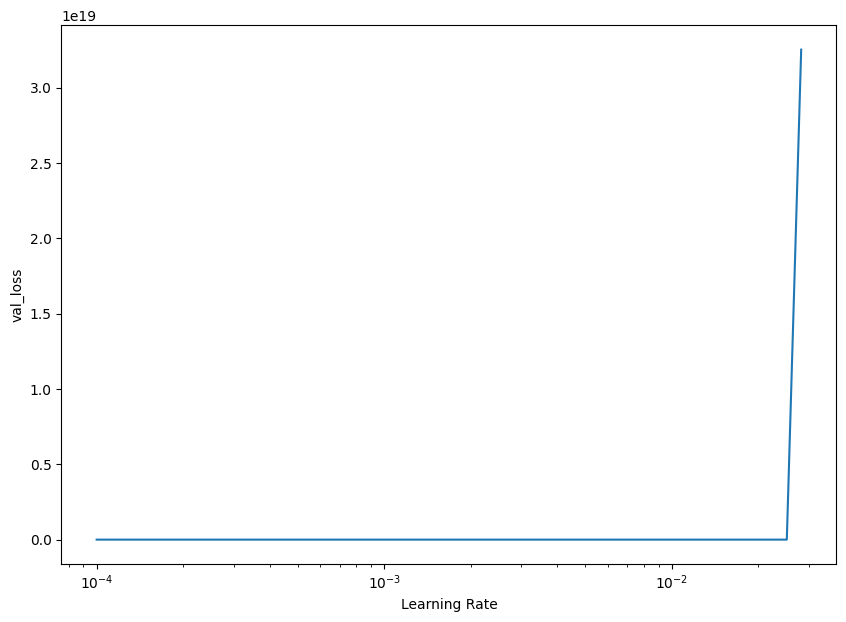

In [3]:
# Defining the InceptionV3 model, without top layer with imagenet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add a top / fully-connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Construct the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Train the model on the new data for a few epochs
epochs = 50
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler]
                    )

lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['val_loss'])
plt.xlabel('Learning Rate')
plt.ylabel('val_loss')
plt.show()

In [4]:
minimum = min(history.history['val_loss'])
index = history.history['val_loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.00022387211385683394


In [5]:
# Defining the InceptionV3 model, without top layer with imagenet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add a top / fully-connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Construct the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=["accuracy"])

# Train the model on the new data for a few epochs
epochs = 50

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator
                    )

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 528s 24s/step - accuracy: 0.3832 - loss: 1.3292 - val_accuracy: 0.3333 - val_loss: 1.6994
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.7013 - loss: 0.7317 - val_accuracy: 0.5764 - val_loss: 1.5074
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.8206 - loss: 0.4998 - val_accuracy: 0.5903 - val_loss: 1.7446
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8869 - loss: 0.3156 - val_accuracy: 0.6458 - val_loss: 1.7836
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9416 - loss: 0.2576 - val_accuracy: 0.7014 - val_loss: 1.3416
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9584 - loss: 0.1301 - val_accuracy: 0.6250 - val_loss: 1.8394
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.9235 - loss: 0.2282 - val_accuracy: 0.7569 - val_loss: 1.2123
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.9641 - loss: 0.1178 - val_accuracy: 0.7431 - val_lo

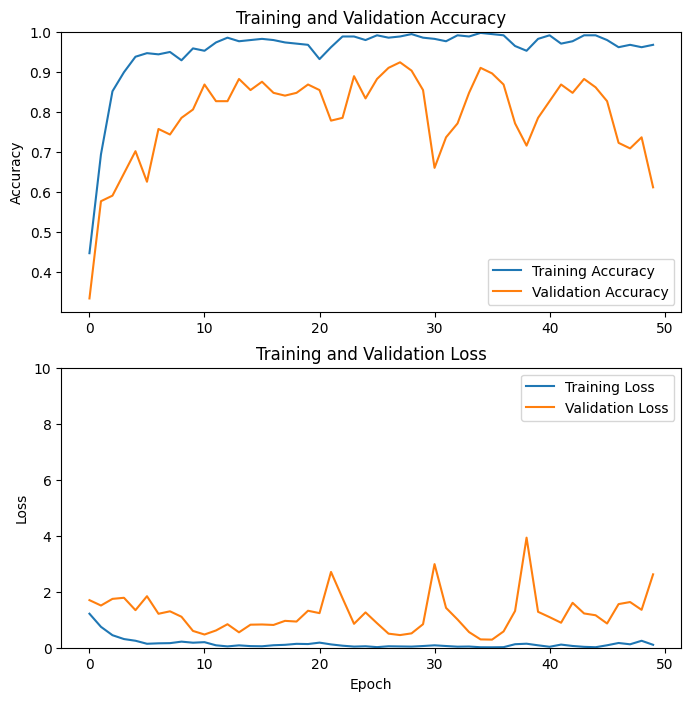

Training Results:
~Accuracy~
Max (best) accuracy: 0.9970238208770752 at epoch 35
Min (worst) accuracy: 0.4464285671710968 at epoch 1
Median accuracy: 0.976190447807312
Mean accuracy: 0.9531547600030899

~Loss~
Min (best) loss: 0.015280363149940968 at epoch 36
Max (worst) loss: 1.2145675420761108 at epoch 1
Median loss: 0.08676617592573166
Mean loss: 0.14243274768814446

~Final Training Performance~
Accuracy: 0.6934523582458496, Loss: 1.4591238498687744

Validation Results:
~Accuracy~
Max (best) accuracy: 0.9236111044883728 at epoch 28
Min (worst) accuracy: 0.3333333432674408 at epoch 1
Median accuracy: 0.8263888955116272
Mean accuracy: 0.7911111098527909

~Loss~
Min (best) loss: 0.28887665271759033 at epoch 36
Max (worst) loss: 3.9306957721710205 at epoch 39
Median loss: 1.1327995657920837
Mean loss: 1.2194188737869263

~Final Validation Performance~
Accuracy: 0.6111111044883728, Loss: 2.6211016178131104


In [6]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_generator, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(validation_generator, verbose=0)))

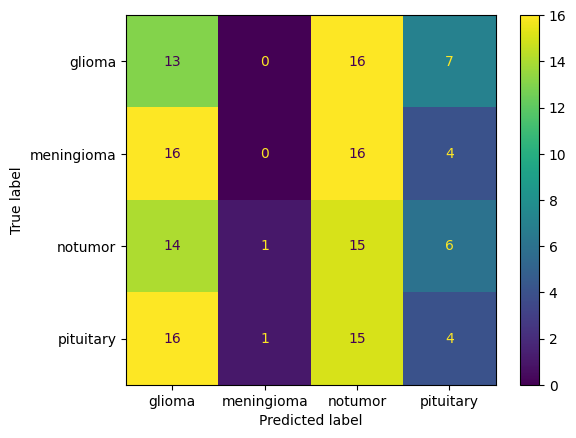

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Get the predicted probabilities for the validation data
predictions = model.predict(validation_generator, verbose=0)

# Convert predictions to label indices
y_pred = np.argmax(predictions, axis=1)

# Extract true labels from the validation data
for i in range(len(validation_generator)):
    X, y = validation_generator[i]
    y_true.extend(np.argmax(y, axis=1))

# Calculate and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot()
plt.show()
